# Data Preprocessing

## Load Data

In [3]:
import os

# Define the HuggingFace repository and local path
ct_filename = "ct.nii.gz"
pancreas_segmentations_filename = "segmentations/pancreas.nii.gz"

data_folder = "./data"
encoded_images_dir = os.path.join(data_folder, "encoded_imgs")

os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl')
import pickle

with open(os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl'), 'rb') as f:
    enc_healthy_cubes = pickle.load(f)

with open(os.path.join(encoded_images_dir, 'enc_pancreatic_tumor_cubes.pkl'), 'rb') as f:
    enc_pancreatic_tumor_cubes = pickle.load(f)

In [4]:
len(enc_healthy_cubes.values())

42

## Unfortunately some of the CTs have less than 10 samples bcs. they ended up being out of range

- [ ] TODO Reduce to min. no. samples of all CTs

In [5]:
import torch

def process_and_stack_tensors(enc_pancreatic_tumor_cubes):
    """
    Process the tensors in the dictionary:
    1. Stack the tensors, ignoring empty lists.
    2. Take tensors with at least 5 entries along the first dimension.
    3. Threshold them to 5 entries, dropping those with fewer than 5 entries.
    4. Stack all the processed tensors along a new axis.

    Parameters:
    enc_pancreatic_tumor_cubes (dict): The input dictionary with lists of tensors.

    Returns:
    torch.Tensor: A tensor with all the processed tensors stacked along a new axis.
    """
    # Stack the tensors, ignoring empty lists
    stacked_inner_lists = [torch.stack(inner_list).squeeze(1) for inner_list in enc_pancreatic_tumor_cubes.values() if inner_list]

    # Filter and reduce the tensors to have exactly 5 entries along the first dimension
    filtered_and_reduced_tensors = [tensor[:5] for tensor in stacked_inner_lists if tensor.shape[0] >= 5]

    # Stack all the processed tensors along a new axis
    if filtered_and_reduced_tensors:
        final_tensor = torch.stack(filtered_and_reduced_tensors)
    else:
        final_tensor = torch.tensor([])  # Return an empty tensor if no tensors meet the criteria

    return final_tensor

In [6]:
enc_pancreatic_tensors = process_and_stack_tensors(enc_pancreatic_tumor_cubes)
enc_healthy_tensors = process_and_stack_tensors(enc_healthy_cubes)

print(enc_pancreatic_tensors.shape)
print(enc_healthy_tensors.shape)

torch.Size([13, 5, 8, 24, 24, 24])
torch.Size([42, 5, 8, 24, 24, 24])


In [7]:
final_tensor = torch.cat([enc_healthy_tensors, enc_pancreatic_tensors], dim=0)
final_tensor.shape

torch.Size([55, 5, 8, 24, 24, 24])

In [8]:
healthy_labels = torch.zeros(enc_healthy_tensors.shape[0])
pancreatic_labels = torch.ones(enc_pancreatic_tensors.shape[0])

final_labels = torch.cat([healthy_labels, pancreatic_labels], dim=0)
final_labels.shape

torch.Size([55])

In [9]:
features = final_tensor
labels = final_labels

# Dimensionality Reduction and Clustering

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%pip install umap-learn
import umap.umap_ as umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
# Assuming 'features' is your data of shape (n_samples, 8, 24, 24, 24)
# and 'labels' contains the labels (0 for healthy, 1 for unhealthy)

# Flatten the features
n_samples = features.shape[0]
flattened_features = features.reshape(n_samples, -1)

# Standardize the features
scaler = StandardScaler()
flattened_features_std = scaler.fit_transform(flattened_features)

## 🧪 Experiment: is it better to reduce the dimensionality before clustering, or vice versa?

### ⚙️ Setup

#### Dimensionality Reduction

##### Principal Component Analysis

<font color="green">Good news! 95% of the variance is explained by 50 components, just like we discussed!</font>

In [11]:
# PCA Dimensionality Reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
features_pca = pca.fit_transform(flattened_features_std)
print('PCA - Number of components to retain 95% variance:', pca.n_components_)
print('Explained variance ratio per component:', pca.explained_variance_ratio_)
print('Total explained variance:', np.sum(pca.explained_variance_ratio_))

PCA - Number of components to retain 95% variance: 50
Explained variance ratio per component: [0.05285411 0.03111285 0.02878589 0.02534071 0.0246702  0.02390832
 0.02326699 0.02266867 0.02202206 0.02180872 0.02140613 0.02132495
 0.02090604 0.02069652 0.02045745 0.02028527 0.02005069 0.01962716
 0.01943715 0.01931673 0.01897915 0.01870987 0.01847431 0.01814526
 0.0178865  0.01760858 0.0175637  0.01741141 0.01723742 0.01712158
 0.01689542 0.01651524 0.01633855 0.0161289  0.016052   0.01595112
 0.01573147 0.01531301 0.01520748 0.01493081 0.0147759  0.01448342
 0.01445503 0.01425533 0.01413239 0.01389771 0.01372826 0.01310133
 0.0127369  0.01222237]
Total explained variance: 0.9559370483969043


##### t-SNE

In [12]:
# t-SNE Dimensionality Reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(flattened_features_std)
# t-SNE does not provide explained variance

##### UMAP

In [13]:
# UMAP Dimensionality Reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_reducer.fit_transform(flattened_features_std)
# UMAP does not provide explained variance

/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


#### Clustering

In [14]:
def cluster_and_evaluate(features, labels, method='kmeans', **kwargs):
    if method == 'kmeans':
        clustering = KMeans(random_state=42, **kwargs)
    elif method == 'agglomerative':
        clustering = AgglomerativeClustering(**kwargs)
    elif method == 'dbscan':
        clustering = DBSCAN(**kwargs)
    else:
        raise ValueError("Unsupported clustering method.")
    
    clusters = clustering.fit_predict(features)
    
    # Evaluate clustering
    if len(set(clusters)) > 1 and len(set(clusters)) < len(features):
        silhouette_avg = silhouette_score(features, clusters)
        calinski_harabasz = calinski_harabasz_score(features, clusters)
        davies_bouldin = davies_bouldin_score(features, clusters)
    else:
        silhouette_avg = calinski_harabasz = davies_bouldin = np.nan
    
    print(f"Clustering method: {method}")
    print(f"Parameters: {kwargs}")
    print(f"Number of clusters found: {len(set(clusters))}")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")
    print(f"Davies-Bouldin Score: {davies_bouldin}\n")
    
    return clusters

### 🚀 Evaluation

#### Option A: Dimensionality Reduction before Clustering

In [21]:
print("Option A: Dimensionality Reduction (PCA) → Clustering\n")

# Try different numbers of PCA components
# 100 is too much, we have less than that samples
for n_components in [10, 20, 50, 55]:
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(flattened_features_std)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"PCA with {n_components} components - Explained variance: {explained_variance:.4f}")
    
    # K-Means Clustering
    clusters_pca_kmeans = cluster_and_evaluate(features_pca, labels, method='kmeans', n_clusters=2)

Option A: Dimensionality Reduction (PCA) → Clustering

PCA with 10 components - Explained variance: 0.2720
Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.1949420166487766
Calinski-Harabasz Score: 8.78833193233198
Davies-Bouldin Score: 2.1841724914768244



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


PCA with 20 components - Explained variance: 0.4727
Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.10328314847737638
Calinski-Harabasz Score: 4.9061180331265835
Davies-Bouldin Score: 2.912437570597657



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


PCA with 50 components - Explained variance: 0.9559
Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.0101514884655781
Calinski-Harabasz Score: 2.2487345337092632
Davies-Bouldin Score: 4.46969680641417



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


PCA with 55 components - Explained variance: 1.0000
Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.009979428095415098
Calinski-Harabasz Score: 2.148213087965991
Davies-Bouldin Score: 4.675121921290959



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
print("Option A: Dimensionality Reduction (t-SNE) → Clustering\n")

# Clustering on t-SNE reduced data
clusters_tsne_kmeans = cluster_and_evaluate(features_tsne, labels, method='kmeans', n_clusters=2)

Option A: Dimensionality Reduction (t-SNE) → Clustering



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.3336087763309479
Calinski-Harabasz Score: 31.428115418575704
Davies-Bouldin Score: 1.116853217065876



In [17]:
print("Option A: Dimensionality Reduction (UMAP) → Clustering\n")

# Clustering on UMAP reduced data
clusters_umap_kmeans = cluster_and_evaluate(features_umap, labels, method='kmeans', n_clusters=2)

Option A: Dimensionality Reduction (UMAP) → Clustering

Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.39218664169311523
Calinski-Harabasz Score: 45.88323736142226
Davies-Bouldin Score: 0.9691291146415337



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Option B: Clustering First, Then Dimensionality Reduction

Option B: Clustering → Dimensionality Reduction



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering method: kmeans
Parameters: {'n_clusters': 2}
Number of clusters found: 2
Silhouette Score: 0.00997942809541555
Calinski-Harabasz Score: 2.1482130879659946
Davies-Bouldin Score: 4.67512192129096

PCA for visualization - Explained variance: 0.0839


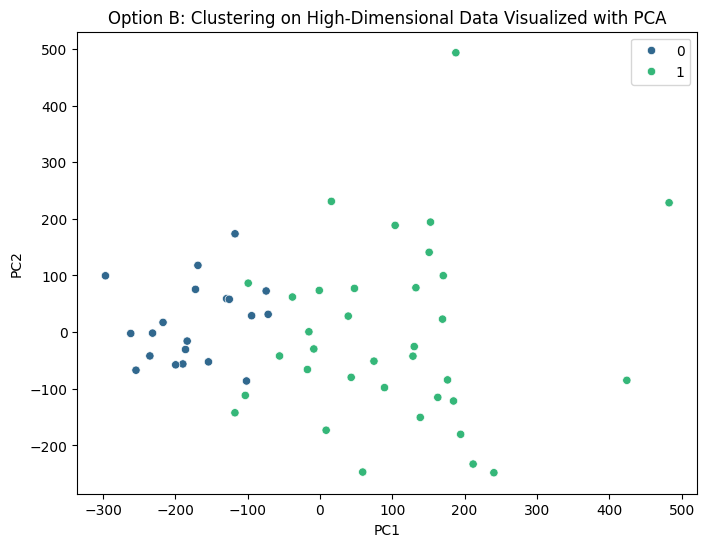

In [18]:
print("Option B: Clustering → Dimensionality Reduction\n")

# Clustering on high-dimensional data
clusters_highdim_kmeans = cluster_and_evaluate(flattened_features_std, labels, method='kmeans', n_clusters=2)

# Dimensionality Reduction for visualization
pca_vis = PCA(n_components=2)
features_pca_vis = pca_vis.fit_transform(flattened_features_std)
explained_variance_vis = np.sum(pca_vis.explained_variance_ratio_)
print(f"PCA for visualization - Explained variance: {explained_variance_vis:.4f}")

# Plot the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=features_pca_vis[:, 0], y=features_pca_vis[:, 1], hue=clusters_highdim_kmeans, palette='viridis')
plt.title('Option B: Clustering on High-Dimensional Data Visualized with PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Basic Method that also plots, but not Hyperparameter Search

Shape of flattened features: torch.Size([55, 552960])
Shape after PCA: (55, 50)
Adjusted Rand Index: 0.007182915711246789
Silhouette Score: 0.0101514884655781


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


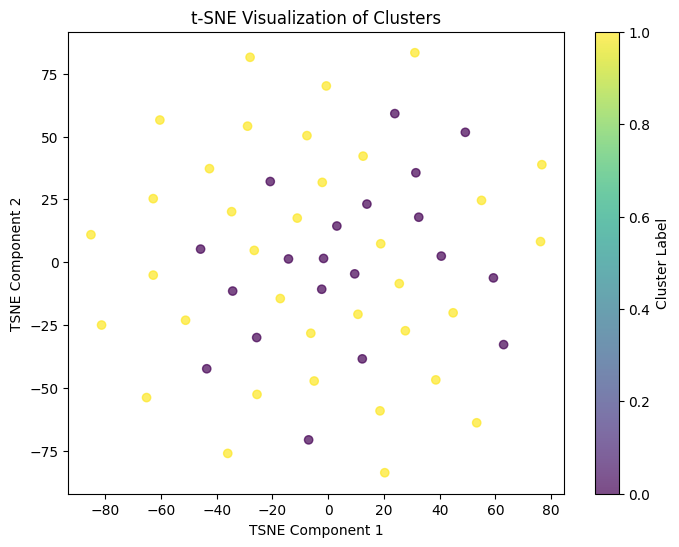

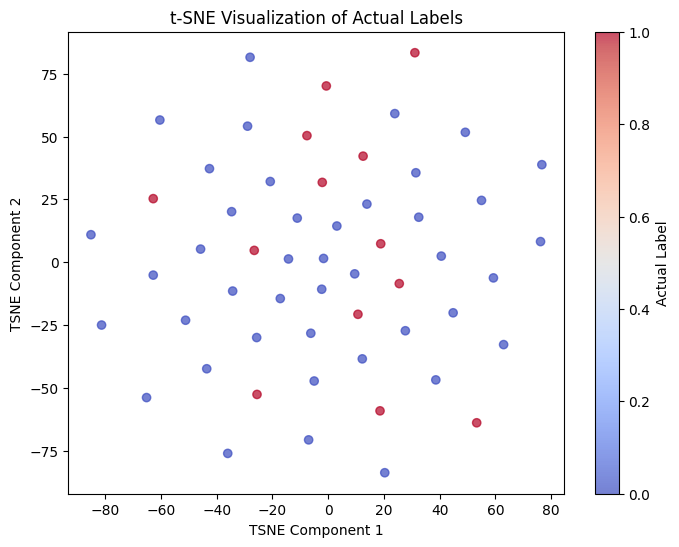

In [8]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load your data
# Assuming 'features.npy' is of shape (n_samples, 8, 24, 24, 24)
# and 'labels.npy' contains the labels (0 for healthy, 1 for unhealthy)

# Flatten the features
n_samples = features.shape[0]
flattened_features = features.reshape(n_samples, -1)
print('Shape of flattened features:', flattened_features.shape)
# Output: (n_samples, 110592)

# Standardize the features
scaler = StandardScaler()
flattened_features_std = scaler.fit_transform(flattened_features)

# Dimensionality reduction using PCA
# Adjust n_components based on the explained variance ratio
pca = PCA(n_components=50, random_state=42)
features_pca = pca.fit_transform(flattened_features_std)
print('Shape after PCA:', features_pca.shape)

# Clustering using KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features_pca)

# Evaluate clustering
ari = adjusted_rand_score(labels, clusters)
sil_score = silhouette_score(features_pca, clusters)
print('Adjusted Rand Index:', ari)
print('Silhouette Score:', sil_score)

# Visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Optional: Visualize actual labels
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title('t-SNE Visualization of Actual Labels')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(label='Actual Label')
plt.show()

# Suggestions:
# - Experiment with different numbers of PCA components.
# - Try other clustering algorithms like DBSCAN or Agglomerative Clustering.
# - Consider using UMAP for dimensionality reduction.
# - Since you have labels, you might also train a classifier to evaluate feature separability.